In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.transforms import ToTensor
import torchvision.models as models
from PIL import Image
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sb

from pathlib import Path

from pyproj import Transformer

from functools import partial
from collections import OrderedDict

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import MeanShift, estimate_bandwidth
from itertools import cycle

import time
import pickle

In [2]:
n_components = 3

component_selected = 0

cluster = True

chip_size = 64
train_ratio = 0.8 # ratio of train size to fullsize

data_root = "saga_data"
n_channels = len(os.listdir(data_root)) // 2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

L2_param = 1e-5

transformer = Transformer.from_crs("epsg:4326", "epsg:3413")

models_dir = 'res_comp/'
Path(models_dir).mkdir(parents=True, exist_ok=True)

train_max_epoch = 50

In [3]:
with open('components_analysis/mix_n{}.npy'.format(n_components), 'rb') as f:
    mix = np.load(f)

In [4]:
df = pd.read_csv('components_analysis/df_unique.csv', header=[0])
df['proj_x'], df['proj_y'] = transformer.transform(df.latitude,df.longitude)

In [5]:
df['latitude'].mean()

68.7847711764706

In [6]:
df.longitude.mean()

-133.49410438502673

In [7]:
for i in range(mix.shape[1]):
    df['component{}'.format(i)] = mix[:, i]

In [8]:
df.head()

,latitude,longitude,time,borehole,depth,frozen,cryostructures,visible_ice,ASTM_2488,materials,...,bottom_of_interval,month,year,month_cyclic,visible_ice_code,proj_x,proj_y,component0,component1,component2
0,69.16162,-133.08682,2012-03-21T00:00:00Z,0170-1-10,0.85,1,NaN,Pure ice,ICE,Ice,...,1.4,3,2012,3,4,-2.280305e+06,-76170.639998,3.020992,0.351328,-1.557754
1,69.16105,-133.08880,2012-03-21T00:00:00Z,0170-1-12,1.20,1,Nf,No visible ice,GP-GM,Coarse till,...,2.4,3,2012,3,0,-2.280371e+06,-76093.964428,0.000000,0.000000,0.000000
2,69.15849,-133.08865,2012-03-20T00:00:00Z,0170-1-17,1.45,1,NaN,No visible ice,SM-SC,Sand,...,2.3,3,2012,3,0,-2.280657e+06,-76109.484296,-5.746523,-0.052054,-0.600771
3,69.15908,-133.08968,2012-03-20T00:00:00Z,0170-1-18,1.20,1,NaN,No visible ice,ML,Silt,...,2.3,3,2012,3,0,-2.280593e+06,-76066.285386,-5.746523,-0.052054,-0.600771
4,69.15886,-133.09090,2012-03-21T00:00:00Z,0170-1-19,1.20,1,Nf,No visible ice,GP,Gravel,...,2.4,3,2012,3,0,-2.280619e+06,-76018.544396,-5.850486,-0.905609,-0.506412


In [9]:
len(df)

561

## Cluster boreholes into groups

In [10]:
X = np.array(df[['latitude','longitude', ]])

In [11]:
# The following bandwidth can be automatically detected using
bandwidth = estimate_bandwidth(X, quantile=0.02)
# bandwidth = estimate_bandwidth(X, quantile=0.0)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
#labels looks like [0, 0, 0, 1, 1, 1, 1, 2, 2,....]

cluster_centers = ms.cluster_centers_

n_clusters = cluster_centers.shape[0]

# turn off clustering
if not cluster:
    cluster_centers = X
    n_clusters = cluster_centers.shape[0]
    labels = np.arange(n_clusters)
    print("No Clustering")

print("number of estimated clusters : %d" % n_clusters)

number of estimated clusters : 52


In [12]:
cluster_centers.shape

(52, 2)

In [13]:
cluster_centers_proj = transformer.transform(cluster_centers[:,0], cluster_centers[:,1])

In [14]:
import gmplot as gp

with open('components_analysis/apikey.txt') as f:
    apikey = f.readlines()[0]

gmap = gp.GoogleMapPlotter(df.latitude.mean(), df.longitude.mean(), 8, apikey = apikey)
gmap.scatter(cluster_centers[:, 0], cluster_centers[:, 1], size = 100, marker=False) 
gmap.draw('components_analysis/cluster_centers.html')

In [15]:
sources = np.load('components_analysis/horizontal_sources_n{}.npy'.format(n_components))

In [16]:
sources.shape

(561, 3)

In [17]:
sources_clustered = np.zeros([n_clusters, n_components])

for i in range(n_clusters):
    ind = (labels==i)
    sources_clustered[i, :] = np.mean(sources[ind,:], axis=0)

In [18]:
class SAGA10mDataset(Dataset):
    def __init__(self, data_root, df, sources, chip_size=32):
        
        self.df = df
        self.mix = mix
        
        # 1 pixel = 10|
        self.n_pixels = 10000
        self.base_y = -9995
        self.base_x = -239995
        
        self.chip_size = chip_size
        
        self.trans = transforms.ToTensor()
        
        self.n_channels = len(os.listdir(data_root))//2
        
        print("Dataset contains {} channels".format(self.n_channels))
        
        self.preloaded = torch.zeros(self.n_channels, self.n_pixels, self.n_pixels*2)
        
        file_list = os.listdir(data_root)
        
        for i in range(self.n_channels):
            # name = file.split('_')[0]
            # print(name)
            self.preloaded[i, :, 0:10000] = self.trans(Image.open(data_root + os.path.sep + file_list[i*2]))
            self.preloaded[i,:, 10000:20000] = self.trans(Image.open(data_root + os.path.sep + file_list[i*2 + 1]))
        
        self.preloaded[self.preloaded < -9000] = 0
        
        print('Dataset initialized')
        
    def __len__(self):
        return n_clusters

    def __getitem__(self, idx):
        
        lat = cluster_centers[idx][0]
        lng = cluster_centers[idx][1]
        
        x = cluster_centers_proj[0][idx]
        y = cluster_centers_proj[1][idx]
        
        
        pixel_len = 10
        
        
        
        x_start = max(0 , np.round((x - self.base_x) / pixel_len - self.chip_size/2).astype(int))
        x_end = min(20000, x_start + self.chip_size)
        
        y_start = max(0, np.round((- y) / pixel_len - self.chip_size/2).astype(int))
        y_end = min(20000, y_start + self.chip_size)
        

        image= self.preloaded[:, y_start:y_end, x_start:x_end]
        
        sources_tensor = torch.tensor(sources[idx]).float()
        
        return {'image': image, 'label': sources_tensor, \
                'latitude': lat, 'longitude': lng}

In [19]:
full_dataset = SAGA10mDataset(data_root, df, sources_clustered, chip_size)

Dataset contains 3 channels


c:\users\mouju\appdata\local\programs\python\python38\lib\site-packages\PIL\Image.py:3011: DecompressionBombWarning: Image size (100000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Dataset initialized


In [20]:
# check max min values

minval = 1000
maxval = 0

for i in range(len(full_dataset)):
    image = full_dataset[i]['image'].flatten()
    
    minval = min(minval, min(image))
    maxval = max(maxval, max(image))

print(minval)
print(maxval)

# normalize image values
magnitude_max = max(abs(minval), maxval)

for i in range(len(full_dataset)):
    full_dataset[i]['image'] = full_dataset[i]['image'] / magnitude_max
    

tensor(-10.8875)
tensor(216.6639)


In [21]:
def train(trainloader, testloader, print_epochs = False, loss_fn = torch.nn.BCELoss()):
    
    model= models.resnet18()
    model.conv1 = nn.Conv2d(n_channels, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    model.fc = nn.Linear(in_features=512, out_features=n_components)
    
    model.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), weight_decay = L2_param)

    epoch_loss = np.zeros([train_max_epoch, 2])
    for epoch in range(train_max_epoch):  # loop over the dataset multiple times

        model.train()
        running_loss_sum = 0.0
        for i, data in enumerate(trainloader, 0): # loop over each sample
            # get the inputs; data is a list of [inputs, labels]
            image, labels = data['image'].to(device), data['label'].to(device)

            predicted = model(image)
            
            
#             print(predicted.squeeze().get_device())
#             print('\n')
#             print(labels.get_device())
            
            
            # squeeze: return tensor with all dimensions of size 1 removed
            loss = loss_fn(predicted.squeeze(), labels)
            
            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            running_loss_sum += loss.item()

        # ----------- get validation loss for current epoch --------------
        model.eval()
        validation_loss_sum = 0.0
        for i, data in enumerate(testloader, 0): # loop over each sample

            image, labels = data['image'].to(device), data['label'].to(device)

            predicted = model(image)
            
            loss = loss_fn(predicted.squeeze(), labels)

            validation_loss_sum += loss.item()

        # ---------------- print statistics ------------------------

        running_loss = running_loss_sum / len(trainloader)
        validation_loss = validation_loss_sum / len(testloader)
        epoch_loss[epoch, :] =  [running_loss, validation_loss]
        
        if print_epochs:
            print('epoch %2d: running loss: %.5f, validation loss: %.5f' %
                          (epoch + 1, running_loss, validation_loss))
        
        torch.save(model.state_dict(), os.path.join(models_dir, 'epoch-{}.pt'.format(epoch+1)))
    
    if print_epochs:
        print('Finished Training')
        
    return epoch_loss
        
def test(epoch_loss, print_model_epoch = False):
    
    # ------ select model ---------
    ind = np.argmin(epoch_loss[:, 1])
    
    
    model= models.resnet18()
    model.conv1 = nn.Conv2d(n_channels, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    model.fc = nn.Linear(in_features=512, out_features=n_components)
    
    model.load_state_dict(torch.load('{}epoch-{}.pt'.format(models_dir, ind+1)))
    
    model.to(device)
    
    if print_model_epoch:
        print("epoch {} model selected".format(ind+1))
    
    # evaluate model on test set
    model.eval()

    with torch.no_grad():
        test_results = []
        
        for i, data in enumerate(testloader, 0):
            image, labels = data['image'].to(device), data['label'].to(device)
            # y_test.append(label.numpy().list())
            # print(label.shape)
            # print(images.shape)

            output = model(image)
            
            test_results.extend(output)
            
    return test_results

In [22]:
train_size = int(train_ratio * len(full_dataset))
test_size = len(full_dataset) - train_size

# batchsize can cause error when last leftover batchsize is 1, batchnorm cannot function on 1 sample data
batchsize = 32
while(train_size % batchsize == 1):
    batchsize+=1
print(batchsize)

# train_data, test_data = torch.utils.data.random_split(full_dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))
train_data, test_data = torch.utils.data.random_split(full_dataset, [train_size, test_size])

trainloader = DataLoader(train_data, batch_size=batchsize, shuffle=True)
testloader = DataLoader(test_data, batch_size=batchsize, shuffle=True)

32


In [23]:
len(trainloader)

2

In [24]:
test_length = len(test_data)

In [25]:
for it in range(1):
    start = time.time()
    
    epoch_loss = train(trainloader,testloader, print_epochs = True, loss_fn = nn.HuberLoss())
    test_results= test(epoch_loss, print_model_epoch = True)

    end = time.time()
    
    print('iteration {} elapsed time: {}'.format(it+1, end-start))



c:\users\mouju\appdata\local\programs\python\python38\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch  1: running loss: 0.97743, validation loss: 5.09482
epoch  2: running loss: 0.57829, validation loss: 1.15083
epoch  3: running loss: 0.09898, validation loss: 3.88422
epoch  4: running loss: 0.09742, validation loss: 2.17747
epoch  5: running loss: 0.05970, validation loss: 3.85774
epoch  6: running loss: 0.03940, validation loss: 3.80938
epoch  7: running loss: 0.03784, validation loss: 4.00305
epoch  8: running loss: 0.02091, validation loss: 0.90019
epoch  9: running loss: 0.01783, validation loss: 0.80668
epoch 10: running loss: 0.01073, validation loss: 0.78609
epoch 11: running loss: 0.01008, validation loss: 0.55302
epoch 12: running loss: 0.00776, validation loss: 0.27087
epoch 13: running loss: 0.00938, validation loss: 0.19827
epoch 14: running loss: 0.00442, validation loss: 0.14764
epoch 15: running loss: 0.00927, validation loss: 0.12427
epoch 16: running loss: 0.00679, validation loss: 0.06142
epoch 17: running loss: 0.00347, validation loss: 0.02851
epoch 18: runn

In [26]:
test_results = torch.vstack(test_results)

test_results = test_results.cpu().detach().numpy()

In [27]:
test_results.shape

(11, 3)

In [28]:
test_labels = np.zeros([len(test_data), n_components])
for i in range(len(test_data)):
    test_labels[i, :] = test_data[i]['label']

In [29]:
test_labels.shape

(11, 3)

In [30]:
err = ((test_results - test_labels).flatten())
np.mean(err * err)



0.005086104348396926

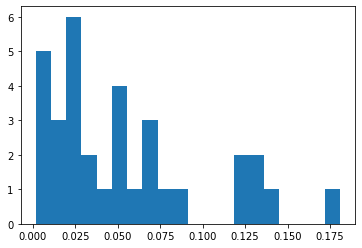

In [31]:
plt.hist(abs(err), bins=20)
plt.show()

In [32]:
stacked_array = np.hstack((test_labels, test_results))

cols_a = ['ICA_{}'.format(i) for i in range(n_components)]
cols_b = ['Resnet_{}'.format(i) for i in range(n_components)]

cols = cols_a + cols_b

stacked_df = pd.DataFrame(stacked_array, columns = cols)

In [33]:
def component_coherence(i): 
    sb.lmplot(x='ICA_{}'.format(i), y='Resnet_{}'.format(i), data=stacked_df);
    plt.axis('equal')
# #     plt.scatter(test_labels[:, i], test_results[:, i])
    plt.savefig('components_analysis/horizontal_coherence_cluster{}_chip{}_n{}_channel{}.png'.format(cluster, chip_size,n_components, i))
    plt.show()

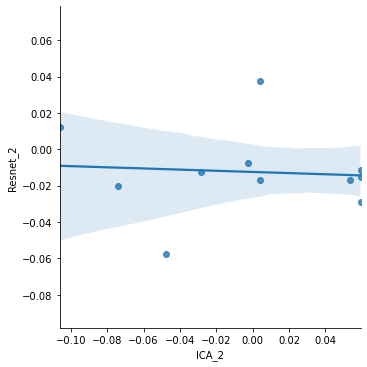

In [39]:
component_coherence(2)

In [35]:
# for channel in range(3):
    
#     base = "components_analysis/components_strengths_{}_n{}_channel{}.html"
#     name_res = base.format("resnet", n_components, channel)
#     name_nonres = base.format("nonres", n_components, channel)
    
#     plot_component_strength_map(test_results[:, channel], channel, name_res, \
#                                 latitudes_map, longitudes_map)
    
#     plot_component_strength_map(test_labels[:, channel], channel, name_nonres, \
#                                 latitudes_map, longitudes_map)
    

In [36]:
# n_max_bh = 50

# plt.figure()
# plt.subplot(311)
# plt.imshow(bh_obs[:, 0:n_max_bh], interpolation = 'none', extent=[0,n_max_bh-1, 5, 0])
# ax = plt.gca()
# ax.set_aspect(2)
# plt.colorbar()
# plt.title("Observed Visible Ice")
# plt.xlabel("Boreholes")
# plt.ylabel('Depth')

# plt.subplot(312)
# plt.imshow(ica_approximation[:, 0:n_max_bh], interpolation = 'none', extent=[0,n_max_bh-1, 5, 0])
# ax = plt.gca()
# ax.set_aspect(2)
# plt.colorbar()
# plt.title("ICA Approximation")
# plt.xlabel("Boreholes")
# plt.ylabel('Depth')

# plt.subplot(313)
# plt.imshow(res_approximation[:, 0:n_max_bh], interpolation = 'none', extent=[0,n_max_bh-1, 5, 0])
# ax = plt.gca()
# ax.set_aspect(2)
# plt.colorbar()
# plt.title("Resnet")
# plt.xlabel("Boreholes")
# plt.ylabel('Depth')

# # plt.savefig('components_analysis/comparison_n{}.png'.format(n_components))
# plt.show()